# Tutoriel sur l'utilisation de l'altimètre laser d’OSIRIS-REx (OLA)

**Tutoriel:** Ce tutoriel couvre les techniques d'acquisition, de prétraitement et de visualisation des données de nuages de points capturées par le capteur OLA d'OSIRIS-REx sur l'astéroïde Bennu.<br> 
**Mission et instrument:** OSIRIS-REx et Altimètre Laser<br>
**Objectif astronomique:** Astéroïde Bennu<br>
**Données:** Produits de données calibrés d'OSIRIS-REx<br>
**Outils primaires:** PDS4 Tools, Open3D<br>
**Systeme requise:** 8 GB de RAM minimum<br>
**Niveau du tutoriel:** Intermédiaire<br>

### Imports
- [Requests](https://requests.readthedocs.io/en/latest/): Utilisé pour le téléchargement de données par le biais de requêtes http.
- [Zipfile](https://docs.python.org/3/library/zipfile.html): Utilisé pour l'extraction des données. 
- [OS](https://docs.python.org/3/library/os.html): Utilisé dans l'exploration des répertoires.
- [IO](https://docs.python.org/3/library/io.html): Utilisé pour l'interprétation d’information d'entrée/sortie. 
- [Numpy](https://numpy.org/doc/): Utilisé pour les tableaux généraux et le traitement. 
- [Matplotlib](https://matplotlib.org/stable/index.html): : Utilisé pour la création des diagrammes. 
- [PDS4 Tool](https://pdssbn.astro.umd.edu/tools/pds4_tools_docs/current/user_manual.html#user-manual): Utilisé pour le traitement et la conversion du type de PDS4 à autre données.
- [Open3D](http://www.open3d.org/): Utilisé pour l'analyse et la visualisation des données de nuages de points.


## Informations sur la mission 

La mission Origins, Spectral Interpretation, Resource Identification, Security-Regolith Explorer (OSIRIS-REx) utilisant le Touch-And-Go Sample Acquisition Mechanism (TAGSAM) a été conçue pour être le premier satellite à collecter un échantillon scientifique et à le renvoyer de l'astéroïde Bennu.<br>

Cet astéroïde a été choisi pour plusieurs raisons. La plus intéressante est que Bennu est très ancien, près de 4,5 milliards d'années. Les scientifiques pensent qu'il s'est formé aux tout premiers instants de notre système solaire, dans les première 10 millions d'années qui ont suivi leur formation. En raison de cet âge, elle nous donne un aperçu de la composition de notre système solaire au moment primitif. Plus précisément, on pense qu'il s'est détaché d'un astéroïde riche en carbone, qui potentiellement contenant des molécules organiques qui auraient pu contribuer à la vie sur n’autre terre.<br>

La contribution du Canada à la mission OSIRIS-REx était l'altimètre laser (OLA), un système capable de scanné l'astéroïde depuis une distance jusqu'à sept kilomètres.<br>
- L'OLA envoie des impulsions de lasers, qui sont enregistrées et traitées pour renvoyer les coordonnées et la distance des points dans un nuage de points.  

Cet outil a prouvé sa valeur en fournissant aux scientifiques un modèle 3D précis et détaillé de la surface de Bennu, permettant d'analyser la forme, la pente, la rugosité, etc.<br>  
Ces informations ont ensuite été utilisées pour déterminer un site de sélection. Plusieurs sites ont été présélectionnés, et Nightingale a été choisi pour son mélange de régolithe bien préservé, son grand cratère d'échantillonnage de 140 m et sa trajectoire d'accès relativement sûre.<br><br>



## Configuration 

In [3]:
import requests, zipfile, os, io, numpy, pandas
from pds4_tools import pds4_read
import open3d as o3d
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Sources de données des instruments

Les données que nous utiliserons pour ce tutoriel sont stockées dans l'archive [Planetary Data System (PDS)](https://pds.nasa.gov/tools/about/). Cet outil est maintenu par NASA et contient le stockage à long terme des produits de données. Cette archive est bien documentée et contient des [données de mission](https://arcnav.psi.edu/urn:nasa:pds:context:investigation:mission.orex) et d'autres informations utiles pour sélectionner les données appropriées.<br>

Il est également possible d'accéder aux données par le biais du portail d'information et de [données ouvertes de l'Agence spatiale canadienne](https://donnees-data.asc-csa.gc.ca/en/dataset?q=osiris-rex&science_admin=True&sort=score+desc%2C+metadata_modified+desc).
 

### Exploration et sélection des données 
Pour ce tutoriel, nous nous concentrerons sur l'utilisation des données disponibles à partir de l'ensemble [d'altimètres laser OSIRIS (OLA)](https://arcnav.psi.edu/urn:nasa:pds:orex.ola). Comme nous sommes principalement intéressés à travailler avec des données de nuages de points dans le cadre de ce tutoriel, nous choisirons un produit de données pré-calibrées. Cela signifie que les données brutes de l'instrument ont été traitées et calibrées pour obtenir des mesures interprétables.  


In [7]:
url =  'https://sbnarchive.psi.edu/pds4/orex/downloads_ola/ola_data_calibrated_v2_detailed_survey.zip' 

### Téléchargement et extraction de la source
En utilisant la librairie requests, nous allons faire une requête HTTP à PDS. Cette requête renvoie un fichier zip de la source, nous devons donc extraire les fichiers localement en utilisant la bibliothèque zipfile.

In [8]:
raw_path = os.path.basename(os.path.normpath(url))
raw_path = os.path.splitext(raw_path)[0] + "_data"

if not os.path.exists(raw_path): 
    os.mkdir(raw_path)

# streaming is helpful when downloading large data packets
response = requests.get(url, stream = True)

# if the https requests is made, the files are downloaded and unzipped to the new dir
if response.ok: 
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    zip_file.extractall(raw_path)
    print('Extraction Complete')

Extraction Complete


## Exploration du type de données PDS4
Les fichiers extraits sont au  [format PDS4](https://pds.nasa.gov/datastandards/documents/), un format de fichier développé par NASA pour la distribution standardisée de produits de données. Ce format comprend un fichier binaire brut avec un schéma et des en-têtes spécifiés par un fichier xml d'accompagnement. Pour ingérer des données interprétables aux fins de ce tutoriel, nous utiliserons la bibliothèque PDS4 Tools.<br>

Après avoir ingéré les données, nous pouvons également explorer les étiquettes de données disponibles dans le tableau.  
 


In [9]:
lowest_dirs = list()

# walking through the directory to lowest path and extracting file names from that path
for root, dirs, _ in os.walk(raw_path):
    if not dirs:
        lowest_dirs.append(root)
        raw_files = os.listdir(lowest_dirs[0])
        
file_list = [name for name in raw_files if name.endswith('.xml')]

example_file = lowest_dirs[0] + '/' + file_list[0]
    
# lazy load checks if the structure is already in memory
structures = pds4_read(example_file, lazy_load=True)
    
table = structures[0]

# displaying table headers
table.info()

Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190222_ola_scil2id03000.xml
Found a Table_Binary structure: calibrated
Fields for Table_Binary 'calibrated' (23 fields x 1139456 records): 

met
met_offset
utc
et
scan_ola_time
power_cycle
laser_selection
scan_mode
flag_status
range
azimuth
elevation
intensity_t0
intensity_trr
x
y
z
elongitude
latitude
radius
scx
scy
scz


### Sélection des données et exploration des schémas
D'après ce qui précède, nous pouvons voir qu'il existe plusieurs options à sélectionner. Pour nos besoins, nous utiliserons les variables de données de x, y, z, les valeurs des coordonnées des points capturés dans le nuage de points. De plus amples informations sur le schéma sont aussi disponibles [ici](https://sbnarchive.psi.edu/pds4/orex/orex.ola/document/).<br>

Nous chercherons à convertir ces données en un tableau numpy plus facile à utiliser, et à les enregistrer en tant que fichier de données de nuage de points (pcd).


In [13]:
data_list = []

pcd_path = os.path.basename(os.path.normpath(url))
pcd_path = os.path.splitext(pcd_path)[0] + "_pcds"

if not os.path.exists(pcd_path): 
    os.mkdir(pcd_path)

# for each file, it is reading it in using pds4 tools, and selcting the x, y, z data
for i in file_list:
        
        current_file =  lowest_dirs[0]  + '/' + i
        structures = pds4_read(current_file, lazy_load=True)
        
        # selecting headers with names of x, y, z (coordinate data)
        lbl_data = structures[0]['x','y','z']
        
        points = pandas.DataFrame(lbl_data)

        np_points = points.to_numpy()
                    
        # use if wish to load data from memory
        # data_list.append(np_points)
                
        new_name = pcd_path + "/" + i.split('.')[0] + "_converted.pcd"
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np_points)
        # saving the loaded point cloud data strcuture to a point cloud data file
        o3d.io.write_point_cloud(new_name, pcd)
        
print('Point Cloud Conversion Complete')

Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190222_ola_scil2id03000.xml
Found a Table_Binary structure: calibrated
Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190223_ola_scil2id03001.xml
Found a Table_Binary structure: calibrated
Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190224_ola_scil2id03002.xml
Found a Table_Binary structure: calibrated
Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190225_ola_scil2id03003.xml
Found a Table_Binary structure: calibrated
Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey/20190226_ola_scil2id03004.xml
Found a Table_Binary structure: calibrated
Processing label: ola_data_calibrated_v2_detailed_survey_data\orex.ola\data_calibrated_v2\detailed_survey

### Visualizing Data 
Maintenant que les données sont disponibles dans un format accessible, nous allons commencer à les explorer à l'aide de la bibliothèque Open3D. Cette bibliothèque possède de nombreuses fonctionnalités utiles et a été développée comme une bibliothèque moderne de traitement de données 3D similaire à OpenCV.<br>

Cette bibliothèque possède de nombreuses fonctionnalités utiles et repose sur l'utilisation de structures de données 3D pour un traitement et une visualisation efficaces.<br>

Malgré cette efficacité, le traitement des nuages de points reste coûteux en termes de calcul. Nous allons donc chercher à sous-échantillonner les nuages de points par le biais du sous-échantillonnage des voxels. Nous obtenons ainsi une grille uniforme sur laquelle les points sont régulièrement sous-échantillonnés.

In [14]:
# the voxel size determines the size of the voxel grid for downsampling (the larger the number the more downsampling)
voxel_size = 0.5
pcds = []

raw_files = os.listdir(pcd_path)
# selecting all point cloud data files
file_list = [name for name in raw_files if name.endswith('.pcd')]

for i in file_list:   
        current_file = pcd_path + "/" + i
        pcd = o3d.io.read_point_cloud(current_file)
        
        # function to downsample
        pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
        pcds.append(pcd_down) 

# this will visualize on your local machine, with example seen below
o3d.visualization.draw_geometries(pcds)

#### Nuage de Points Primaires
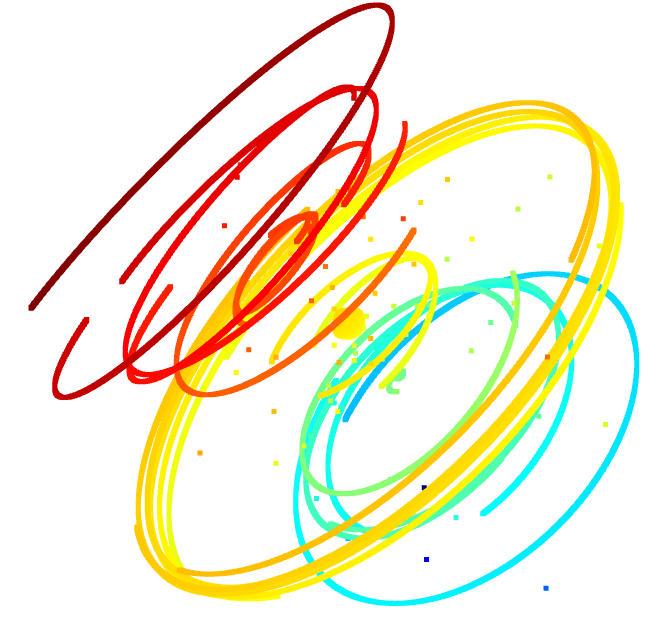

### Le nettoyage et la combinaison des nuages de points
Comme on peut le voir dans la visualisation ci-dessus, plusieurs artefacts sont présents dans le nuage de points, notamment les données d'orbite du satellite. Ces éléments doivent être supprimés et nettoyés avant toute analyse supplémentaire. Cela peut être fait directement en recadrant les données dans l'outil de visualisation. Cependant, nous allons chercher à spécifier une boîte de délimitation automatique pour recadrer les artefacts.<br> 

Bien que cela n'entre pas dans le cadre de ce tutoriel, certains nuages de points nécessitent un enregistrement des nuages de points, une technique permettant d'aligner des nuages de points mal alignés. Les nuages de points de ce tutoriel sont peu désalignés et cette étape peut être ignorée. Toutefois, si vous souhaitez en savoir plus, cliquez 
[ici](http://www.open3d.org/docs/latest/tutorial/Advanced/multiway_registration.html). 

In [15]:
coeff = [1, -1]
# L specifies the size of the bounding box to crop the asteroid
L = 300
pcd_combined = o3d.geometry.PointCloud()

for p in pcds:  
    corners = []
    # determines the centroid of the point cloud (correaltes to center of asteroid)
    coords = p.get_center().reshape(-1,3)
    
    # for loop for setting corners of a bounding box of length L from centroid
    for i in coeff:
        for j in coeff:
            for k in coeff: 
                x_corn = coords[0, 0] + i*L
                y_corn = coords[0, 1] + j*L
                z_corn = coords[0, 2] + k*L
                
                corners.append([x_corn, y_corn, z_corn])
                
    corn_arr = numpy.array(corners)
    
    # creates a red orientated bounding box (obb)
    box_center = o3d.geometry.PointCloud()
    box_center.points = o3d.utility.Vector3dVector(corn_arr)
    obb = box_center.get_oriented_bounding_box()
    obb.color = (0, 1, 0)
    
    # crops asteroid using bounding box 
    crop_pcd = p.crop(obb)
    
    # combining point clouds to a single point cloud, this removes duplicate points
    pcd_combined += crop_pcd

# statistical removal of outliers, the lower the std_ratio the more aggressive it is
cl_pcd, ind = pcd_combined.remove_statistical_outlier(nb_neighbors=20, std_ratio=10)
o3d.visualization.draw_geometries([cl_pcd])

#### Nuage de Points Traité
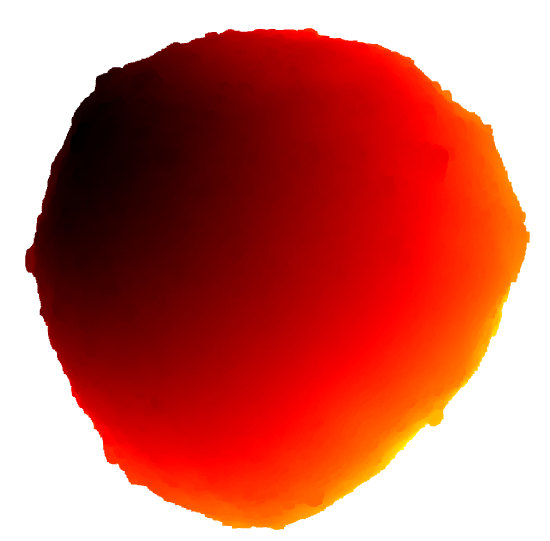

#### Sauvegarde du nuage de points traité

In [16]:
o3d.io.write_point_cloud("bennu_cloud.pcd", cl_pcd)
print('Point Cloud Saved')

Point Cloud Saved


#### Déséchantillonnage supplémentaire pour un traitement avancé

In [4]:
voxel_size = 1
pcd = o3d.io.read_point_cloud("bennu_cloud.pcd")
pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
o3d.visualization.draw_geometries([pcd])

## Regroupement spatial d'applications basé sur la densité et le bruit (DBSCAN)

Une façon utile d'explorer les données des nuages de points est de procéder à la segmentation et à l'étiquetage. Ce processus peut être réalisé de diverses manières, notamment par la segmentation plane, la vision par ordinateur, etc. Ici, nous allons explorer l'utilisation de l'analyse en cluster via  [DBSCAN](http://www2.cs.uh.edu/~ceick/7363/Papers/dbscan.pdf) pour déterminer s'il existe des grappes particulières à haute densité sur Bennu.<br>

DBSCAN a besoin de deux hyper-paramètres pour fonctionner, notamment l'intervalle à chercher par point (epsilon) et le nombre minimum de points par cluster. Ces paramètres peuvent être déterminés de plusieurs façons, notamment par itération, intuition et calcul direct. Nous allons d'abord explorer une technique de [détermination optimale de l'epsilon](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) à l'aide d'un graphique qui ressemble en forme de coude.


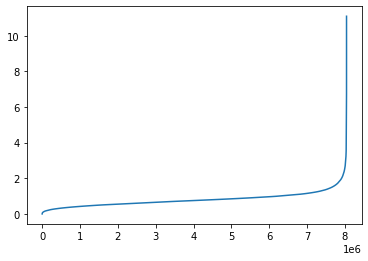

In [18]:
pcd_dbscan = pcd

dist_list = []

# creating a kd-tree for fast retreival of nearest neighbors
pcd_tree = o3d.geometry.KDTreeFlann(pcd_dbscan)

for i in range(len(numpy.asarray(pcd.points))): 
    # for each point in the point cloud returns the 3 nearest neighbors distances (4 is used since also returns self)
    [k, _, dist] = pcd_tree.search_knn_vector_3d(pcd_dbscan.points[i], 4)

    for j in range(1, k):
        dist_list.append(dist[j])

# sorting distances
dist_list.sort()

# plotting graph
dist_arr = numpy.asarray(dist_list)
plt.plot(dist_arr)


### Valeur d'Epsilon et résultats de DBSCAN
Comme on peut le voir dans le graphique ci-dessus, le taux de changement le plus élevé se produit à une distance de 2 mètres (m), ce qui suggère le choix d'une valeur d'epsilon identique. Ce paramètre et le nombre minimum de points peuvent être ajustés pour obtenir des résultats différents, et nous vous suggérons d'explorer les effets de l'ajustement de ces paramètres.

In [20]:
# values to adjust 
min_points = 10
eps = 2

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = numpy.array(
        pcd_dbscan.cluster_dbscan(eps = eps, min_points = min_points, print_progress=True)) # dbscan function
    
max_label = labels.max()

# setting a different color for each cluster with no clusters equaling black
colors = plt.get_cmap("gist_ncar")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0

pcd_dbscan.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd_dbscan])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 10
point cloud has 10 clusters


#### DBSCAN Résultats 
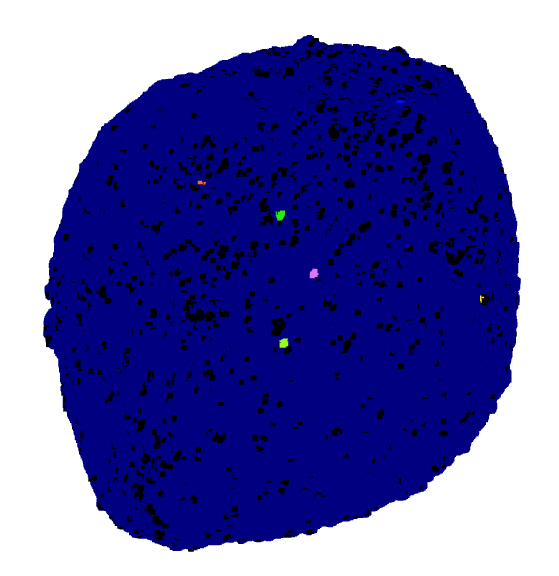

### Autres visualisations et traitements
Plusieurs autres techniques sont potentiellement utiles pour la visualisation des données de nuages de points. Il s'agit notamment de techniques telles que le développement d'une coque convexe (l'enveloppe de tous les points dans un espace), la visualisation de la grille de voxels ou la visualisation d'un octree, qui sont toutes décrites ci-dessous.


In [23]:
pcd_processed = pcd

pcd_processed.scale(1 / numpy.max(pcd.get_max_bound() - pcd.get_min_bound()), center=pcd_processed.get_center())

# assigning a random color to each point in the point cloud 
pcd_processed.colors = o3d.utility.Vector3dVector(numpy.random.uniform(0, 1, size=(len(pcd_processed.points), 3)))

# determination of the convex hull including edges of the polygon
conv_hull, _  = pcd_processed.compute_convex_hull()
conv_hull.compute_vertex_normals() # edges
o3d.visualization.draw_geometries([conv_hull])

# displaying the voxel grid
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_processed, voxel_size= 0.01) #voxel size correlates to grid
o3d.visualization.draw_geometries([voxel_grid])

# displaying octree
octree = o3d.geometry.Octree(max_depth=4) # depth specifies the level of detailed stored
octree.convert_from_point_cloud(pcd_processed, size_expand=0.01)
o3d.visualization.draw_geometries([octree])

#### Enveloppe Convexe
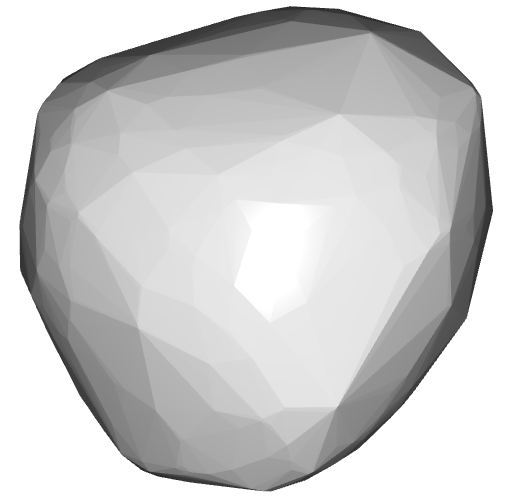

#### Grille Voxel
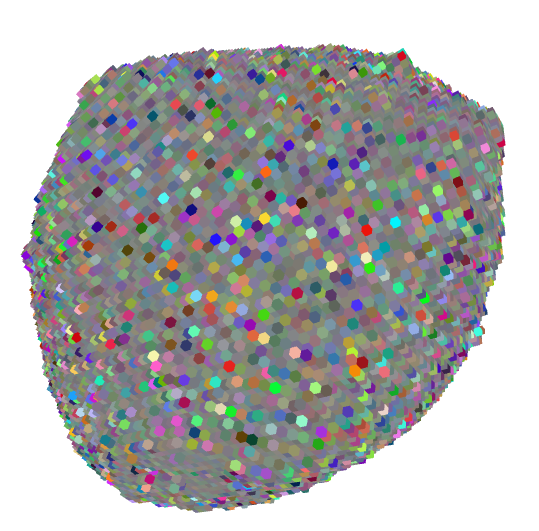

#### Octree
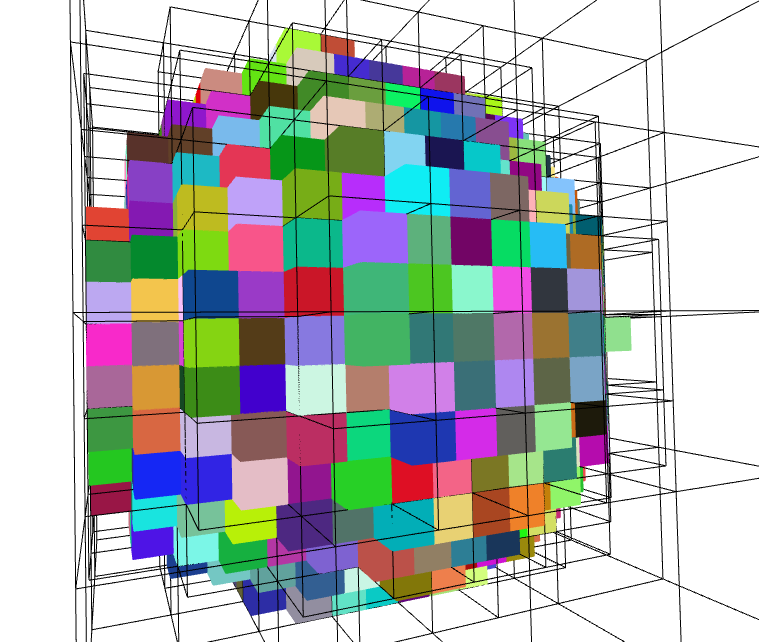

## Visualisation de la différence de hauteur relative de Bennu
Une visualisation utile pour les besoins de la mission OSIRIS-REx est la détermination d'un modèle numérique d'élévation et la visualisation de la différence relative d'altitude sur la surface de Bennu. Ceci peut être réalisé grâce à diverses techniques, notamment l'ajustement d'ellipses sur la surface de Bennu. Dans le cadre de ce tutoriel, nous chercherons à réaliser une version simplifiée en déterminant la distance relative par rapport au centroïde de Bennu.


In [25]:
# getting center coordinate of point cloud, and converting to point cloud data type
coords = pcd.get_center().reshape(-1,3)
coord_center = o3d.geometry.PointCloud()
coord_center.points = o3d.utility.Vector3dVector(coords)

# determine the distance between every point and the center
center_distances = pcd.compute_point_cloud_distance(coord_center)

# getting the distances and normalizing to use in range for coloring
center_distances = numpy.asarray(center_distances)
max_dist = center_distances.max()
normalized = (center_distances-min(center_distances)) / (max(center_distances)-min(center_distances))

# creating color map and assigning colors
colors = plt.get_cmap("terrain") (normalized)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd])

#### Différence de Hauteur 
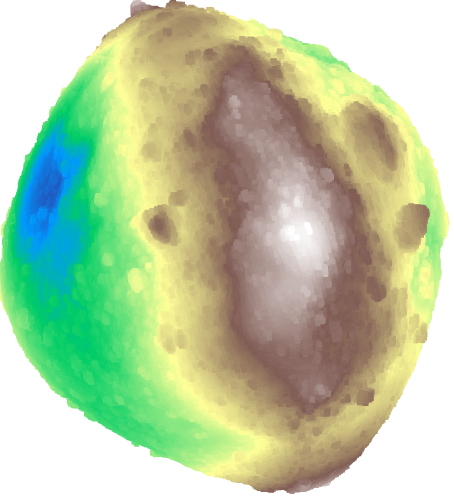

## Génération de maillage par reconstruction de Poisson
Les nuages de points sont utiles pour une variété d'analyses et de visualisations. Cependant, l'application d'un maillage peut être préférable. Ci-dessous, nous générons un maillage pour l'exportation et le traitement ultérieur.

In [5]:
# further downsampling (this greatly reduces detail but makes it processable in a resonable amount of time)
voxel_size = 5
pcd = o3d.io.read_point_cloud("bennu_cloud.pcd")
pcd = pcd.voxel_down_sample(voxel_size=voxel_size)

# estimating the normals for the point cloud
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(50)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=12) # depth specifies detail in resulting polygon

mesh.compute_vertex_normals()

o3d.io.write_triangle_mesh("bennu_mesh.ply", mesh)

o3d.visualization.draw_geometries([mesh])

[Open3D DEBUG] Input Points / Samples: 68662 / 68662
[Open3D DEBUG] #   Got kernel density: 1.845 (s), 721.082 (MB) / 721.082 (MB) / 994 (MB)
[Open3D DEBUG] #     Got normal field: 0.655 (s), 942.059 (MB) / 942.059 (MB) / 994 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 5.335825e-05 / 3.663684e+00
[Open3D DEBUG] #       Finalized tree: 1.849 (s), 959.008 (MB) / 959.008 (MB) / 1187 (MB)
[Open3D DEBUG] #  Set FEM constraints: 2.151 (s), 744.363 (MB) / 959.008 (MB) / 1187 (MB)
[Open3D DEBUG] #Set point constraints: 0.514 (s), 716.324 (MB) / 959.008 (MB) / 1187 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 8532819 / 1324656 / 8427137
[Open3D DEBUG] Memory Usage: 716.336 MB
[Open3D DEBUG] # Linear system solved: 5.451 (s), 763.301 (MB) / 959.008 (MB) / 1187 (MB)
[Open3D DEBUG] Got average: 0.119 (s), 742.527 (MB) / 959.008 (MB) / 1187 (MB)
[Open3D DEBUG] Iso-Value: 4.997663e-01 = 3.431495e+04 / 6.866200e+04
[Open3D DEBUG] #          Total Solve:      18.6 (s),     959.0

#### Normales Affiché
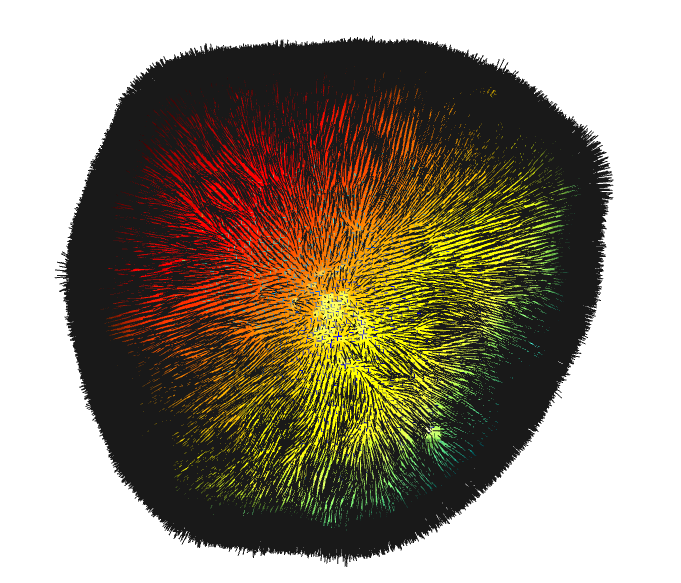

#### Maille Affiché
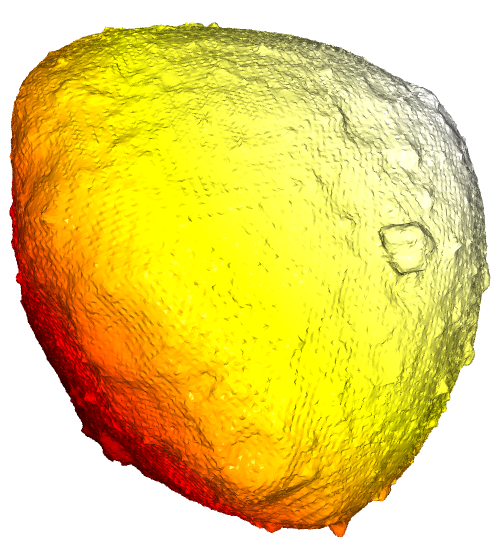